## Animation for collective information cascades in adaptive networks
## Few feautures :
### The mode is a continuous time model
### Dyanmics on the network is based on D-W model and LIF-model. Dyanmics of the network is as follows :
    1. Susceptible (indicated with 1 in this script) can only create (a) or decay (\lambda\) links. 
    2. Infected (indicated with 2 in this script) can only break (b) links but not create/decay any
### No discrete memory term of the D-W model but exponential decay of cumulative dose

### This simulation is for non spatial analysis. By default, it starts off with a gnm random network with 4*N number of edges in total and is for equal birth and death rates. However, the dynamics on the network does not start until the network topology attains a steady state. This is done in order to make the simulation forget the user bias coming from the initalised knn network

### Note : Changes to be made if the simulation is to be run for unequal birth and death rates
    1. Uncomment the block of code containing "w_minus", the birth and death rates
    2. Comment the function below "equal birth and death rates" in the "Function definitions required for the main part of the script."
    3. Uncomment the function below "unequal birth and death rates" in the "Function definitions required for the main part of the script."

#### For any queries, email rachithaiyappa96@gmail.com
### ----------------------------------------------------------------------------------------------------------------------------------------------------

# Importing the required libraries

In [1]:

import networkx as nx #network library to generate inital networks and perform various network operations
from matplotlib import animation #for the animation
import matplotlib.pyplot as plt #for plotting
import numpy as np #for using arrays and vectorising the code wherever possible
import scipy
import random
# import cProfile #for timing the loops
# from numba import jit #numba precomplier to make the code faster
import pandas as pd
import time
import copy

# Variables used in the simulation

### Usually what is changed is dose_quantity,  p_rew_org, start

In [2]:
dataset = 4  #this is used to name the mp4 file being saved at the end of the simulation. Useful for multiple animations of the same parameter set.

N = 100     #Number of nodes on the network
gamma = 1   #decay of cumulative dose per unit time (second). That is, rate of decay of 'D'
T = 100     #total number of seconds the simulation runs for 

dt = 0.05   #seconds. Time step of the simulation. Therefore, the number of simulation steps is T/dt''' 

'''------------------------------------------------------------------------------------------------------------'''

'''dt_netrun can be thought of as a modified 'dt' which is used to speed up the process of
the network topology reaching steady state. 
For example, supposed the rate at which the network topology changes is very small and maybe almost static,
using dt = 0.05 will take the simulation a long time inorder to stabilise the network 
(for the user intialised network) only after which the dynamics on the network starts.
Thus using dt_netrun = 100 or 10 can result in the network topology taking lesser time to stabilise.
Once the network topology reaches a steady state, the orginal dt = 0.05 is used for the remaining of the simulation
involving the coupling between the dynamics on the network and the dynamics of the network'''

'''the following can be modied depending on user preference. 
Here, based the on inution gained and the way the simulations were labelled,
dt_netrun is linked to the value of the dataset which need not be the case for a different user'''

if dataset < 4 :
    dt_netrun = 10
else :
    dt_netrun = dt
    
'''------------------------------------------------------------------------------------------------------------'''

'''Major Dodds-Watts parameters'''
p = 1       #rate of dose transfer (per unit time (second))
p = p*dt    #rate of dose transfer per simulation step
r = 1/dt    #rate at which infected recovers if the conditions are met. 
r = r*dt    #This rate is currently set such that an infected ALWAYS recovers if D drops below d*
rho = 1/dt  #rate at which recovered individuals become re-susceptible
rho = rho*dt #This rate is currently set such that a recovered ALWAYS immediately becomes re-susceptible. 
#Therefore, for the given values of r and rho, no recovered individuals exist in the system at any point of time
#as infected individuals immediately become resusceptible upon dropping below threshold

d_star = 1            #Individual threshold. Homogeneous
dose_quantity = 0.5   #dose quantity being transferred. Homogeneous
D_ini = 3             #The initial cumulative dose of the infected individuals

'''------------------------------------------------------------------------------------------------------------'''

'''initial network parameters'''
# circ_rad = 100      #for a network in which each node is connected to other nodes withing a circle of radius circ_rad
# nn = 10             #the number of nearest neighbours(i.e. k) for a knn network
# average_degree = 10 #for a gnp random network
total_edges = N*4   #for a gnm random network

'''rewiring parameters'''
# rew_r = 25    #radius within which new links can be formed
# density = 1/N #radius within which new links can be formed
# vals = round(1/((density)*(np.pi)*(rew_r*rew_r)),3)
p_rew_org = 1
lamb_da_org = p_rew_org/10

lamb_da = lamb_da_org*dt  #the lambda value used in the animation. 
p_rew = p_rew_org*dt   #the p_rew value used in the animation. 

p_rew_netrun = p_rew_org*dt_netrun     #the p_rew value used for the network topology to reach steady state before starting the actual dynamics
lamb_da_netrun = lamb_da_org*dt_netrun #the lambda value used for the network topology to reach steady state before starting the actual dynamics

'''------------------------------------------------------------------------------------------------------------'''

'''number of infected nodes at the start of the dynamics on the network'''
start = 1

'''tolerance to determine when the network topology has reach steady state after which the animation starts'''
tol = 0.05
steady_counter_val = 500

'''------------------------------------------------------------------------------------------------------------'''

'------------------------------------------------------------------------------------------------------------'

### Uncomment the block of code below if unequal rates of birth and death of links are required

In [3]:
# w_minus = 5 #the death rates 'b' of links (not the same as decay(lambda))
# w_minus = w_minus*dt

# Functions for creating different initial networks
### All graphs are directed. This means that the existence of an edge from node A to node B  does not necessarily mean there exists an edge from node B to node A and vice versa.
### The network outputs coordinates, distance matrix, edge_list and adjacency matrix

### The graph should output coordinates, distance matrix, edge_list and adjacency matrix

In [4]:
'''
obtains the number of nodes N
generates N points
calculates euclidean distance between each pair of points
returns the coordinates of the points and the distance matrix which is N*N shaped
with diagonal entries = 0 as this represents each node's distance to itself.
'''
def calc_dist(N) :
    coords = []
    for counter in range(N) :
        coords.append((N*np.random.random(),N*np.random.random()))

    dist_mat = scipy.spatial.distance.cdist(coords,coords)
    return dist_mat,coords

### 1. metric network

In [5]:
'''network = connect to points withing a circle of radius'''
#creates a link between points/nodes which satisfies the conditions of the network
def coupling(dist_mat,circ_rad) :
    edge_list = []
    edge_mask = (dist_mat<circ_rad) & (dist_mat>0)
    edge_list.extend(np.ndarray.tolist(np.transpose(np.where(edge_mask))))
    return edge_list

### 2. K nearest neighbour network

In [6]:
'''knn network with N number of nodes and each node connected with nn number of nearest neighbours '''
def knn(dist_mat,nn,N) :
    near_neigh = np.argsort(dist_mat)
    selec_near_neigh = np.zeros((N,nn))
    selec_near_neigh = near_neigh[:,0:nn+1]

    edge_list = []
    for i in range(N) :
        for j in range(1,nn+1) :
            link = [i,selec_near_neigh[i,j]]
            edge_list.append(link)

    return edge_list

### 3. Random Network : GNP type

In [7]:
'''random gnp network with N nodes and having an average degree set by user'''
def rand_network(average_degree,N) :
    z1 = np.random.uniform(size = (N,N))
    E,F = np.meshgrid(np.arange(0,N),np.arange(0,N))
    mask = ((average_degree/N) > z1) & (E!=F)
    adjacency_matrix = np.int64(np.zeros(shape=(N,N)))
    adjacency_matrix[mask] = np.int64(1)
    edge_list = []
    edge_list.extend(np.ndarray.tolist(np.transpose(np.where(adjacency_matrix==1))))
    return edge_list,adjacency_matrix

### 4. Random Network : GNM type

In [8]:
'''random gnm network with N nodes and having total number of edges set by the user'''
def rand_net_gnm(total_edges,N) :
    the_graph = nx.gnm_random_graph(N, total_edges,directed=True)
    adjacency_matrix = nx.adjacency_matrix(the_graph)
    adjacency_matrix = np.asarray(adjacency_matrix.todense())
    np.diagonal(adjacency_matrix,0)
    edge_list = []
    edge_list.extend(np.ndarray.tolist(np.transpose(np.where(adjacency_matrix==1))))
    return edge_list

# Function defintions required for the main part of the script

In [9]:
'''infecting 'start' number connected nodes.
This function is obtained from previous works of Dr. Pawel Romanczuk. '''
def InfectNetworkNeighbors(net,seed_node,init_infected_nodes):
     # if in bulk find one node randomly, and infect its neighbours
    infected_nodes = set()
    candidate_nodes = set()
    explored_nodes = set()

    #pick the seed node
    infected_nodes.add(seed_node)
    explored_nodes.add(seed_node)

    curr_node=seed_node

    #add its neighbors to the list of candidates
    for n in net.neighbors(curr_node):
        candidate_nodes.add(int(n))
    #print( curr_node)
    #print( candidate_nodes)

    #while we need to select more nodes...
    while len(infected_nodes) < init_infected_nodes:

        #if there are candidate nodes, select one of them
        if(len(candidate_nodes) > 0):
            new_node = np.random.choice(list(candidate_nodes),1)[0]
            infected_nodes.add(new_node)
            candidate_nodes.remove(new_node)

        elif len(infected_nodes - explored_nodes) > 0:
            curr_node = np.random.choice(list(infected_nodes -
            explored_nodes),1)[0]
            explored_nodes.add(curr_node)
            for n in set(net.neighbors(curr_node)) - infected_nodes:
                candidate_nodes.add(n)

        else:
            print('Initial node infection step failed')
            return None
    return infected_nodes

In [10]:
''' Function to transer doses. This is first step in the the dynamics on the network.
Dose trasnfer occurs from infected to other infected/susceptible nodes'''
# @jit(nopython=True)
def dose(adj_mat,p,partner_state_prev,d) :

    z1 = np.random.uniform(size=(len(adj_mat),len(adj_mat[0])))
    
    dose_transfer_mask = p > z1
    mod_adj_mat = np.multiply(adj_mat,z1) #modifying adjacency matrix to include the proability of dose transfer
    dose_mask = (p>mod_adj_mat) & (adj_mat!=0) & (partner_state_prev == 2)
    d[dose_mask] = dose_quantity #whenever it is possible, dose transfer occurs
    
    return d

# ----------------------------------------------------------------------------------------------------
### For equal birth and death rates 

In [11]:
'''Function which controls the coupling between the states of the nodes and the network topology.
This is the dynamics of the network'''

def rew(p_rew,adjacency_matrix,indi_state_for_rew_prev,OD_mesh2,lamb_da) :
    
    z1_rew_prew = np.random.uniform(size=(len(adj_mat),len(adj_mat[0])))
    z1_rew_lambda = np.random.uniform(size=(len(adj_mat),len(adj_mat[0])))
    
    rew_mask_plus = (p_rew > z1_rew_prew)  & (indi_state_for_rew_prev == 1)
    #Susceptible creates links. Dont break any.  
    adjacency_matrix[rew_mask_plus] = 1
    
    rew_mask_minus1 = (p_rew > z1_rew_prew) & (indi_state_for_rew_prev == 2)
    #Infected breaks links. Dont create any.
    adjacency_matrix[rew_mask_minus1] = 0
    
    rew_mask_minus2 = ((lamb_da*OD_mesh2) > z1_rew_lambda) & (indi_state_for_rew_prev == 1)
    #Susceptible decays links.
    adjacency_matrix[rew_mask_minus2] = 0
    
    #no self links
    np.fill_diagonal(adjacency_matrix,0)
    
    return adjacency_matrix

### For unequal birth and death rates

In [12]:
'''Function which controls the coupling between the states of the nodes and the network topology.
This is the dynamics of the network with unequal birth and death rates'''

# def rew(p_rew,adjacency_matrix,indi_state_for_rew_prev,OD_mesh2,lamb_da) :
    
#     z1_rew_prew = np.random.uniform(size=(len(adj_mat),len(adj_mat[0])))
#     z1_rew_lambda = np.random.uniform(size=(len(adj_mat),len(adj_mat[0])))
    
#     rew_mask_plus = (p_rew > z1_rew_prew)  & (indi_state_for_rew_prev == 1)
#     #Susceptible creates links. Dont break any.  
#     adjacency_matrix[rew_mask_plus] = 1
    
#     rew_mask_minus1 = (w_minus > z1_rew_prew) & (indi_state_for_rew_prev == 2)
#     #Infected breaks links. Dont create any.
#     adjacency_matrix[rew_mask_minus1] = 0
    
#     rew_mask_minus2 = ((lamb_da*OD_mesh2) > z1_rew_lambda) & (indi_state_for_rew_prev == 1)
#     #Susceptible decays links.
#     adjacency_matrix[rew_mask_minus2] = 0
    
#     #no self links
#     np.fill_diagonal(adjacency_matrix,0)
    
#     return adjacency_matrix

'Function which controls the coupling between the states of the nodes and the network topology.\nThis is the dynamics of the network with unequal birth and death rates'

# --------------------------------------------------------------------------------------------------

In [13]:
'''Function which allows the network topology to reach steady state before the actual aniamtion/dynamics begin'''

def let_it_run(p_rew_netrun,adjacency_matrix,OD_mesh2,lamb_da_netrun) :

    z1_rew_prew = np.random.uniform(size=(len(adj_mat),len(adj_mat[0])))
    z1_rew_lambda = np.random.uniform(size=(len(adj_mat),len(adj_mat[0])))
    
    rew_mask_plus = (p_rew_netrun > z1_rew_prew)
    #Susceptible creates links. Dont break any. 
    adjacency_matrix[rew_mask_plus] = 1
    
    rew_mask_minus2 = ((lamb_da_netrun*OD_mesh2) > z1_rew_lambda)
    #Susceptible decays links.
    adjacency_matrix[rew_mask_minus2] = 0
    
    #no self links
    np.fill_diagonal(adjacency_matrix,0)
    
    return adjacency_matrix

In [14]:
'''function to update cumulative doses.
Includes current dose inputs and decay of previous dose inputs'''
def cumu_dose(d,D_prev,gamma) :
    I = d.sum(axis=1).reshape(N,1)
#     I = 0
    D = (D_prev - (gamma*D_prev*dt)) + I
    return D

In [15]:
'''function to synchronously update the states of the nodes of the system.
This is the second step in the dynamics on the network'''
def upd_indi_state(D,d_star,indi_state_prev) :
    
    z2 = np.random.uniform(size=(N,1))
    z3 = np.random.uniform(size=(N,1))
    
    indi_state = indi_state_prev
    
    #susceptible and greater than threshold, gets infected
    indi_state_mask1 = (D>=d_star) & (indi_state_prev==1)
    indi_state[indi_state_mask1] = 2
    
    #infected and drops below threshold, becomes re-susceptible if (r>=z2) & (rho>=z3)
    indi_state_mask21 = (D<d_star) & (indi_state_prev==2) & (r>=z2) & (rho>=z3)
    indi_state[indi_state_mask21] = 1
    
    #infected and drops below threshold, becomes recovered if (r>=z2) & (rho<z3)
    indi_state_mask22 = (D<d_star) & (indi_state_prev==2) & (r>=z2) & (rho<z3)
    indi_state[indi_state_mask22] = 3
    
    #infected and drops below threshold, remains infected if r<z2
    indi_state_mask23 = (D<d_star) & (indi_state_prev==2) & (r<z2)
    indi_state[indi_state_mask23] = 2
    
    return indi_state

In [16]:
'''function to get identify the infected nodes and the suceptible nodes'''
def states(indi_state) :
    infec_indi = []
    suscep_indi = []
    infec_indi = np.transpose(np.where(indi_state==2))
    suscep_indi = np.transpose(np.where(indi_state==1))
    return infec_indi,suscep_indi

In [17]:
'''function keeping track of the new graphs being formed at each simulation step
This helps calculating few properties like out degree and in degree'''
def networkx_graph(coords,edge_list) :
    G = nx.DiGraph()
    pos = {(i): (coords[i][0],coords[i][1]) for i in range(N)}
    G.add_nodes_from(pos.keys())
    G.add_edges_from(edge_list)
    return G

In [18]:
'''function to get the directed edge list from the asymmetrical adjacency matrix'''
def edge_from_adj_mat(adj_mat_list,q):
    edge_list = []
    edge_list.extend(np.ndarray.tolist(np.transpose(np.where(adj_mat_list[q]==1))))

    return edge_list

In [19]:
'''declaring the required data frames'''

#time series of mean out degree as columns
timeseries_out_degree_mean = pd.DataFrame() 

#time series of out degree as columns and rows as nodes
timeseries_out_degree = pd.DataFrame()

# The main part of the script

## Creating the animation

0
re-setting steady_counter!
re-setting steady_counter!
re-setting steady_counter!
re-setting steady_counter!
re-setting steady_counter!
re-setting steady_counter!
re-setting steady_counter!
re-setting steady_counter!
re-setting steady_counter!
re-setting steady_counter!
re-setting steady_counter!
re-setting steady_counter!
re-setting steady_counter!
re-setting steady_counter!
re-setting steady_counter!
re-setting steady_counter!
re-setting steady_counter!
re-setting steady_counter!
re-setting steady_counter!
re-setting steady_counter!
re-setting steady_counter!
re-setting steady_counter!
re-setting steady_counter!
re-setting steady_counter!
re-setting steady_counter!
re-setting steady_counter!
re-setting steady_counter!
re-setting steady_counter!
re-setting steady_counter!
re-setting steady_counter!
re-setting steady_counter!
re-setting steady_counter!
re-setting steady_counter!
re-setting steady_counter!
re-setting steady_counter!
re-setting steady_counter!
re-setting steady_counter!

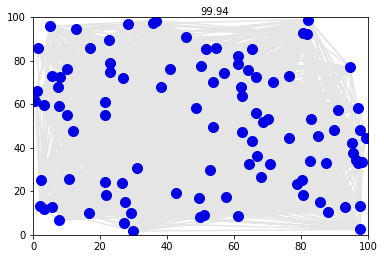

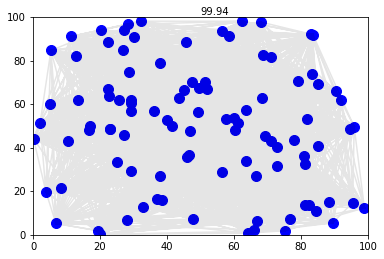

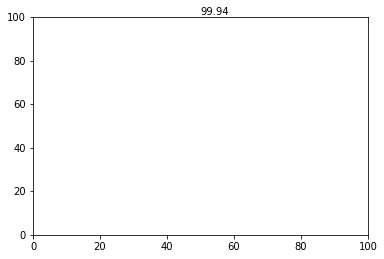

In [20]:
for sim in range(3) : #number of required animations of the same parameter set
    print(sim)
    '''returns coordinates, distance matrix, edge_list and the adjacency matrix'''
    
    t = np.arange(0,T,dt)
    
    dist_mat,coords = calc_dist(N) #node placement
    edge_list = rand_net_gnm(total_edges,N) #setting some sort of initial network. Here knn is chosen
    
    org_adj_mat = np.int64(np.zeros((N,N))) 
    for i in range(len(edge_list)):
        org_adj_mat[edge_list[i][0],edge_list[i][1]] = np.int64(1) #the initial/original adjacency matrix
        
    adj_mat_list = [] #list keeping track of the time series of the adjacency matrices.
    adj_mat = copy.deepcopy(org_adj_mat)
    adj_mat_new = copy.deepcopy(adj_mat)
    adj_mat_list.append(adj_mat_new)

    '''----------------------------------------------------------------------------------------------------
    obtaining a steady network topology before starting the dynamics on the network.
    Start off the simulation with all susceptible nodes. Let the network topology reach a steady state
    Once it reaches a steady stae, then infect 'start' number of nodes on the network and
    begin the actual coupling dynamics'''

    q = 0  #for navigating the list of adjacency matrices
    steady_counter = 0
    df_col = 0 #for navigating the data frames
    no_reset = 0 
    while steady_counter < steady_counter_val : #if counter exceeds the user set value, network topolgy steady state has been reached 
        
        #coords remain the same. Get new edge_list from the latest adjacency matrix
        edge_list = edge_from_adj_mat(adj_mat_list,q)
        G = networkx_graph(coords,edge_list) #networkx graph
        
        timeseries_out_degree.loc[:,df_col] = np.asarray([val for (node, val) in G.out_degree()])
        timeseries_out_degree_mean.loc[0,df_col] = timeseries_out_degree.iloc[:,df_col].mean()
        if df_col-1 >= 0 :
            
            #if new network topology is similar to previous, counter increases
            if np.abs(timeseries_out_degree_mean.loc[0,df_col] - timeseries_out_degree_mean.loc[0,df_col-1]) <= tol :
                steady_counter = steady_counter + 1
            #else start restart the counter from 0
            else :
                steady_counter = 0
                no_reset = no_reset + 1
                print('re-setting steady_counter!')
                
                #to prevent infintie restarts,asssume latest toplogy to be that of steady state. 
                #This will be still better than the initial network
                if no_reset > 100 :
                    print(timeseries_out_degree_mean.loc[0,df_col])
                    break
                
        OD_array = np.asarray([val for (node, val) in G.out_degree()]) #out degree(OD).
        OD_mesh1,OD_mesh2 = np.meshgrid(OD_array,OD_array)    
        adj_mat = let_it_run(p_rew_netrun,adj_mat,OD_mesh2,lamb_da_netrun)
        adj_mat_new = copy.deepcopy(adj_mat)
        adj_mat_list.append(adj_mat_new)
        
#         if (steady_counter % 10) == 0 :
#             print(steady_counter)
        
        q = q + 1 
        df_col = df_col + 1

    '''steady network topology obtained, start the dynamics now
    ---------------------------------------------------------------------------------------------------------------'''
    
    '''re-initialising. This time with the steady state network topology'''
    timeseries_out_degree = pd.DataFrame()
    df_col = 0 #for navigating the data frames
    q = 0      #for navigating the list of adjacency matrices
    edge_list = copy.deepcopy(edge_list)
    G = copy.deepcopy(G)
#     org_adj_mat = copy.deepcopy(adj_mat_new) #ideally, this is now the network topolgy which does not remeber the user bias!
    org_adj_mat = np.int64(np.zeros((N,N)))
    
    numpy_array = np.zeros((N,len(t)),dtype = np.int64) #array with rows as nodes and columns as states of the nodes at every simulation step
    #numpy_array can be used if animation is a separate block of code which needs to be exceuted after the entire simulation.
    #Here, the animation is updated at each step of the simulation
    
    D_array = np.zeros((N,len(t))) #cumulative dose array. Rows are nodes and columns are time series of cumulative doses of each node.
    for i in range(len(edge_list)):
        org_adj_mat[edge_list[i][0],edge_list[i][1]] = np.int64(1) #ideally, this is now the network topolgy which does not remeber the user bias!
        
    adj_mat_list = []
    adj_mat = copy.deepcopy(org_adj_mat)
    adj_mat_new = copy.deepcopy(adj_mat)
    adj_mat_list.append(adj_mat_new)
    
    
    '''choosing initially infected nodes'''
    indi_state = np.random.randint(1,2,size=(N,1))
    infected_nodes = None
    while infected_nodes is None : #infecting 'start' number of network neighbours
        infected_nodes = InfectNetworkNeighbors(G,np.random.randint(N),start)
        print(infected_nodes)
    infected_nodes = np.asarray(list(infected_nodes)).reshape(len(infected_nodes),1)
    indi_state[infected_nodes[:,0],0] = 2

    A,B = np.meshgrid(indi_state,indi_state)
    partner_state = A #state of all the other nodes which can be linked to the focal node. 
    indi_state_for_rew = B

    numpy_array [:,0] = indi_state[:,0]

    indi_state_prev = indi_state
    partner_state_prev = partner_state
    indi_state_for_rew_prev = indi_state_for_rew

    d = 999*np.zeros((len(adj_mat),len(adj_mat[0])))

    D = np.zeros((N,1))
    D[np.where(indi_state==2)] = D_ini
    D_array[:,0] = D[:,0]
    D_prev = D

    '''the main part of the simulation'''
    counter = 0
    for t in np.arange(dt,T,dt) :
        q = q + 1    
        counter = counter + 1
        infec_indi = []
        d = np.zeros((len(adj_mat),len(adj_mat[0])))
        d = dose(adj_mat,p,partner_state_prev,d) #trasnfer doses between interacting nodes

        OD_array = np.asarray([val for (node, val) in G.out_degree()])
        OD_mesh1,OD_mesh2 = np.meshgrid(OD_array,OD_array)
        adj_mat = rew(p_rew,adj_mat,indi_state_for_rew_prev,OD_mesh2,lamb_da) #change network topology using previous states
        adj_mat_new = copy.deepcopy(adj_mat)
        adj_mat_list.append(adj_mat_new)

        #coords remain the same. Get new edge_list from the latest adjacency matrix
        edge_list = edge_from_adj_mat(adj_mat_list,q)
        G = networkx_graph(coords,edge_list) #networkx graph

        D = cumu_dose(d,D_prev,gamma) #update cumulative doses using current doses and previous cumulative dose
        D_array[:,counter] = D[:,0]

        indi_state = upd_indi_state(D,d_star,indi_state_prev) #synchronously update the states of the nodes
        numpy_array[:,counter] = indi_state[:,0]
        A,B = np.meshgrid(indi_state,indi_state)

        infec_indi, suscep_indi = states(indi_state)

        partner_state = A
        indi_state_for_rew = B
        indi_state_prev = indi_state
        partner_state_prev = partner_state
        indi_state_for_rew_prev = indi_state_for_rew

        D_prev = D
        D = np.zeros((N,1))

    t = np.arange(0,T,dt,dtype=np.float16)

    '''-------------------------------------------------------------------------------------------------------
    making the animation'''
    # %matplotlib notebook

    # Set up formatting for the movie files
    Writer = animation.writers['ffmpeg']
    writer = Writer(fps=100, metadata=dict(artist='Me'), bitrate=1800) #fps is frames per second 
    # writer = FasterFFMpegWriter()

    # First set up the figure, the axis, and the plot element to animate
    fig = plt.figure()
    ax = plt.axes(xlim=(0, N), ylim=(0, N))
    infected, = ax.plot([], [],'ro', ls='',markersize=10)
    susceptible, = ax.plot([], [],'bo', ls='',markersize=10)
    edges, = ax.plot([],[],'black',alpha=0.1)
    title = ax.text(N/2,N+1,'blah')

    # initialization function: plot the background of each frame
    def init():
        infected.set_data([],[])
        susceptible.set_data([],[])
        return infected,susceptible,

    def init_custom() :
        infected.set_data([],[])
        susceptible.set_data([],[])
        edges.set_data([],[])
        return infected,susceptible,edges,

    # animation function.  This is called sequentially
    def animate(i):
        title.set_text(t[i])
        ix = []
        iy = []
        where = np.transpose(np.where(numpy_array[:,i]==2))
        for k in range(len(where)) : #nodes
            ix.append(coords[where[k][0]][0])
            iy.append(coords[where[k][0]][1])
        infected.set_data(ix, iy)

        sx = []
        sy = []
        where = []
        where = np.transpose(np.where(numpy_array[:,i]==1))
        for k in range(len(where)) : #nodes
            sx.append(coords[where[k][0]][0])
            sy.append(coords[where[k][0]][1])
        susceptible.set_data(sx, sy)

        edge_list = edge_from_adj_mat(adj_mat_list,i)
        ex = []
        ey = []
        j = 0
        for counter in range(len(edge_list)):
            ex.append(coords[edge_list[j][0]][0])
            ex.append(coords[edge_list[j][1]][0])
            ex.append(None)
            ey.append(coords[edge_list[j][0]][1])
            ey.append(coords[edge_list[j][1]][1])
            ey.append(None)
            j = j + 1
        edges.set_data(ex,ey)

        return infected,susceptible,edges,title,

    # call the animator.  blit=True means only re-draw the parts that have changed.
    anim = animation.FuncAnimation(fig, animate, init_func=init_custom,blit=False, save_count=len(t))

    # anim.save('basic_animation.mp4', fps=10, extra_args=['-vcodec', 'libx264'])
    filename = 'sim_'+str(sim)+'_'+str(dataset)+'_'+'.mp4'
    anim.save(filename, writer=writer)

    # plt.show()